## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [1]:
# imports #

import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

# can start to clean this data by removing symbols like punctuation or other non-word characters
# can further clean by removing articles like "a", "and", "the"
# can then use one-hot-encoding to sift thru the tokens for each email 
# and then run alg to see if the presence of a token can predict whether or not emails are scams

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

<Axes: >

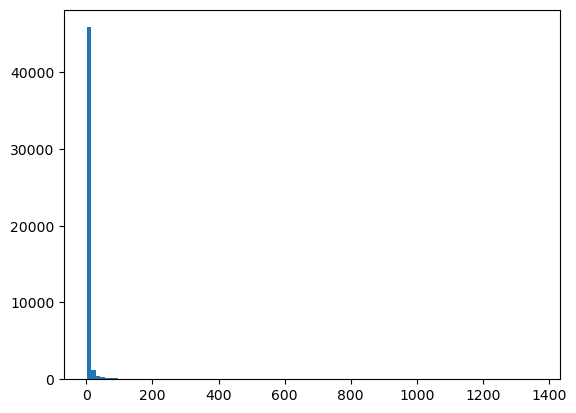

In [3]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns = ['token', 'count'])
gdf['count'].hist(grid = False, bins = 100)

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

In [4]:
gdf['count'].describe()

# out of almost 50000 entries, the frequency is, for the most part, 1 time for these tokens
# the histogram itself is *very* skewed to the right – the description of the histogram shows that
# even 3/4 of the tokens display a frequency of at most 2, which worth noting considering that
# the max frequency is reported to be 1365.. if tokens are on avg appearing only a small handful of times,
# then it's not realistically going to be very predictive of scams

count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: count, dtype: float64

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [5]:
df = pd.read_parquet('Phishing_clean.parquet')

X = df.drop('Email Type', axis = 1)
Y = df['Email Type']

## q3.1 ##

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 125)

In [6]:
## q3.2 ##

linreg = LinearRegression(fit_intercept = False).fit(X_train, Y_train)
y_hat_test_0 = linreg.predict(X_test)
y_hat_train_0 = linreg.predict(X_train)

print('train R^2: ', r2_score(y_hat_train_0, Y_train))
print('test: R^2', r2_score(y_hat_test_0, Y_test))

train R^2:  0.6195789906607536
test: R^2 -0.00026838432685916125


In [7]:
## q3.3 ##

rdf = pd.DataFrame({'variable':linreg.feature_names_in_, 'value':linreg.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs', ascending = False)

# this shows that numbers are most-occurring in these tokens, which are the factors influencing the predictions
# the most. the given R^2 val for the training data wasn't awful.. but not super telling since it was just 0.62,
# but for the test data. it was basically 0, indicating no good correlation whatsoever

,variable,value,abs
1368,-0700,9.755121e+12,9.755121e+12
915,300,-9.514928e+12,9.514928e+12
1061,200,8.920056e+12,8.920056e+12
1695,1000,8.768031e+12,8.768031e+12
668,500,-7.726301e+12,7.726301e+12
...,...,...,...
2176,snow,1.506805e-04,1.506805e-04
565,east,-1.296997e-04,1.296997e-04
1867,index,4.196167e-05,4.196167e-05
1208,sound,-3.147125e-05,3.147125e-05


### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

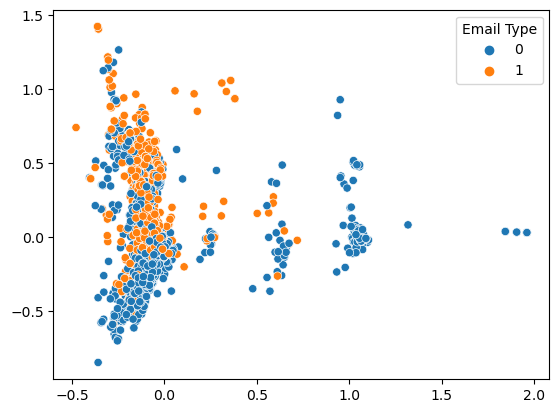

In [8]:
reduction = PCA(n_components = 2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x = Z_test[:, 0], y = Z_test[:, 1], hue = Y_test)

# the plot below shows that the orange dots (scams) seem to coalesce around a low primary component
# and a high secondary component, not being seen past that latter half on the x-axis

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [9]:
reduction = PCA(n_components = 2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

linregK = LinearRegression().fit(Z_train, Y_train)
y_hat_test = linregK.predict(Z_test)
y_hat_train = linregK.predict(Z_train)

print('train R^2: ', r2_score(y_hat_train, Y_train))
print('test R^2: ', r2_score(y_hat_test, Y_test))

# the R^2 values below are much better (in relation to each other) than the prior regression. the test data shows a slightly
# stronger correlation than before (0.62 vs. 0.69) and the test data shows a significantly stronger correlation than
# before (0 vs. 0.59), indicating a stronger model this time around

train R^2:  0.6928975360963747
test R^2:  0.5873905973217179


### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

using PCA vs. original method provided stronger correlation analysis. the components used in PCA are more independent, so there wouldn't be multiple diff IVs having correlation to each other, also easier to decide whether to include 1-2711 components as opposed to 22711 possible components. downside could be that we're able to interpret words, but not the actual components themselves